In [7]:
import pretty_midi
import numpy as np
import datapreparation as datp
reload(datp)
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

In [197]:
### convert all mid to piano_roll
fs=5
files=!ls /home/ahomec/e/eddasilv/datasets/classical/*.mid
for f in files:
    datp.midfile_to_piano_roll(f,fs)

In [199]:
files

['/home/ahomec/e/eddasilv/datasets/classical/bach_846.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/bach_847.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/bach_850.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_im2.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_im5.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_im6.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_opus117_1.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_opus117_2.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_opus1_1.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_opus1_2.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_opus1_3.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_opus1_4.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/brahms_rhap.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/debussy_cc_1.mid',
 '/home/ahomec/e/eddasilv/datasets/classical/debussy_cc_2.mid',
 '/home/ahomec/e/eddasilv/datasets/classica

In [23]:
import model as mymodel
reload(mymodel)
import dataset as dats
reload(dats)

<module 'dataset' from 'dataset.py'>

In [24]:
data = dats.pianoroll_dataset_batch("/home/ahomec/e/eddasilv/datasets/classical/piano_roll_fs5/")

In [ ]:
data_chunks_fs1 = dats.pianoroll_dataset_chunks("/home/ahomec/e/eddasilv/datasets/classical/piano_roll_fs1/",delta=1)
data_chunks_fs5 = dats.pianoroll_dataset_chunks("/home/ahomec/e/eddasilv/datasets/classical/piano_roll_fs5/",delta=5)


In [706]:
model = mymodel.Composer(input_size=128, hidden_size=100, num_tags=data.num_tags(), n_layers=4)
model = model.cuda()
train2(model,data_chunks_fs5,1000,learning_rate = 3e-4,tol=0.000001,batch_size=60,n_split=20)

In [363]:
def generate_round(model,tag,n,k=1,init=None):
    if(init is None):
        init = torch.zeros(size=(k,1,model.input_size)).cuda()
    else:
        k = init.shape[0]
    res = init
    hidden = None
    for i in xrange(n//k):
        init,hidden = model.forward(init,tag,hidden)
        #init = torch.round(torch.exp(init))
        init = torch.round(init/torch.max(init))
        res = torch.cat ( ( res, init ) )
    return res

def gen_music(model,length=1000,init=None,composer=0,fs=100):
    if(init is None):
        song=generate_round(model, torch.LongTensor([composer]).unsqueeze(1).cuda(),length,1)
    else:
        song=generate_round(model, torch.LongTensor([composer]).unsqueeze(1).cuda(),length,1,init)
    res = ( song.squeeze(1).detach().cpu().numpy()).astype(int).T
    datp.visualize_piano_roll(res)
    return datp.embed_play_v1(res,fs)

def gen_music_initkeys(model,length=1000,initkeys=40,composer=0,fs=100):
    init = torch.zeros(size=(1,1,model.input_size)).cuda()
    init[0,0,initkeys]=1
    song=generate_round(model, torch.LongTensor([composer]).unsqueeze(1).cuda(),length,1,init)
    res = ( song.squeeze(1).detach().cpu().numpy()).astype(int).T
    datp.visualize_piano_roll(res)
    return datp.embed_play_v1(res,fs)
    #return song
    
def gen_music_pianoroll(model,length=1000,init=None,composer=0,fs=100):
    if(init is None):
        song=generate_round(model, torch.LongTensor([composer]).unsqueeze(1).cuda(),length,1)
    else:
        song=generate_round(model, torch.LongTensor([composer]).unsqueeze(1).cuda(),length,1,init)
    res = ( song.squeeze(1).detach().cpu().numpy()).astype(int).T
    return res
    #return song

In [136]:
import time

def train(model,data,n_epochs=5000,learning_rate = 0.0001,tol=0.000001,batch_size=100,n_split=100):
    rnn = model
    criterion = nn.BCELoss().cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    acc_loss = []
    songs = []
    old_time = time.time()
    init_time = old_time
    for i in xrange(n_epochs):
        ### training
        data.gen_batch(batch_size,n_split)
        epoch_loss = []
        for item in data:
            optimizer.zero_grad()
            res=model(item[0].cuda(),item[1].cuda())
            loss=criterion(res[0],item[-1].cuda())
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
        epoch_loss = torch.tensor(epoch_loss)
        acc_loss.append(float(epoch_loss.mean()))

        #### loggs and evaluations ####
        if(i%5==0):
            print("epoch "+str(i)+" avg loss="+str(float(epoch_loss.mean())))
        #if(i%10==0):
        #    songs.append(gen_music(rnn))

        if(i%10==0 and i>0):
            new_time = time.time()
            print("epoch "+str(i)+" in time="+str(new_time-old_time))
            old_time = time.time()

        if((i>10) and np.abs(acc_loss[i]-acc_loss[i-1])<tol):
            break
    acc_loss = torch.tensor(acc_loss)
    print("final "+str(i)+" avg loss="+str(acc_loss.mean()))
    print("total time = "+str(time.time()-init_time))
    return acc_loss,songs


def train2(model,data,n_epochs=5000,learning_rate = 0.0001,tol=0.000001,batch_size=100,n_split=100):
    rnn = model
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    acc_loss = []
    songs = []
    old_time = time.time()
    init_time = old_time
    for i in xrange(n_epochs):
        ### training
        data.gen_batch(batch_size,n_split)
        epoch_loss = []
        for item in data:
            optimizer.zero_grad()
            res=model(item[0].cuda(),item[1].cuda())
            loss=criterion(res[0],item[-1].cuda())
            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
        epoch_loss = torch.tensor(epoch_loss)
        acc_loss.append(float(epoch_loss.mean()))

        #### loggs and evaluations ####
        if(i%5==0):
            print("epoch "+str(i)+" avg loss="+str(float(epoch_loss.mean())))
        #if(i%10==0):
        #    songs.append(gen_music(rnn))

        if(i%10==0 and i>0):
            new_time = time.time()
            print("epoch "+str(i)+" in time="+str(new_time-old_time))
            old_time = time.time()

        if((i>10) and np.abs(acc_loss[i]-acc_loss[i-1])<tol):
            break
    acc_loss = torch.tensor(acc_loss)
    print("final "+str(i)+" avg loss="+str(acc_loss.mean()))
    print("total time = "+str(time.time()-init_time))
    return acc_loss,songs

In [ ]:
model_gen = mymodel.Generalist(input_size=128, hidden_size=120, n_layers=4,drop=0.4)
model_gen = model_gen.cuda()

train2(model_gen,data,learning_rate = 0.001,batch_size=100,n_split=5)

In [ ]:
model_gen2 = mymodel.Generalist(input_size=128, hidden_size=120, n_layers=4,drop=0.4)
model_gen2 = model_gen.cuda()

train2(model_gen2,data_chunks_fs5,100,learning_rate = 3e-4,tol=0.000001,batch_size=60,n_split=20)

In [683]:
index=28
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model,40,init=data[index][0][1:5].cuda(),fs=1)

('composer = ', 'mz')


In [684]:
index=28
composer_index=0
print("composer playing = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(int(data_chunks_fs5[index][1]))]))

print("composer song = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(composer_index)]))


#gen_music(model,40,init=data_chunks_fs5[index][0][1:20].cuda(),composer=composer_index,fs=5)

('composer playing = ', 'debussy')
('composer song = ', 'bach')


In [686]:
index=2
composer_index=3
print("composer playing = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(int(data_chunks_fs5[index][1]))]))

print("composer song = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(composer_index)]))


#gen_music(model,100,init=data_chunks_fs5[index][0][1:25].cuda(),composer=composer_index,fs=5)

('composer playing = ', 'mz')
('composer song = ', 'mz')


In [687]:
index=15
composer_index=0
print("composer playing = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(int(data_chunks_fs5[index][1]))]))

print("composer song = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(composer_index)]))


#gen_music(model,80,init=data_chunks_fs5[index][0][1:10].cuda(),composer=composer_index,fs=5)

('composer playing = ', 'mz')
('composer song = ', 'bach')


In [688]:
index=44
composer_index=0
print("composer playing = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(int(data_chunks_fs5[index][1]))]))

print("composer song = ",str(data_chunks_fs5.tags_ids.keys()[data_chunks_fs5.tags_ids.values()\
                                                        .index(composer_index)]))


#gen_music(model,30,init=data_chunks_fs5[index][0][20:25].cuda(),composer=composer_index,fs=2)

('composer playing = ', 'debussy')
('composer song = ', 'bach')


In [689]:
index=0
composer_index=0

print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(composer_index)]))
#gen_music(model_gen,40,init=data[index][0][1:20].cuda(),composer=composer_index,fs=5)

('composer = ', 'bach')


In [693]:
index=7
composer_index=2
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(composer_index)]))
print("song composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model_gen,40,init=data[index][0][1:5].cuda(),composer=composer_index,fs=1)

('composer = ', 'debussy')
('song composer = ', 'brahms')


In [695]:
index=7
composer_index=2
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(composer_index)]))
print("song composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model_gen,40,init=data[index][0][1:5].cuda(),composer=composer_index,fs=1)

('composer = ', 'debussy')
('song composer = ', 'brahms')


In [697]:
index=8
composer_index=1
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(composer_index)]))
print("song composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model,40,init=data[index][0][5:10].cuda(),composer=composer_index,fs=1)

('composer = ', 'brahms')
('song composer = ', 'brahms')


In [700]:
index=45
#print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model_gen,150,init=data[index][0][1:5].cuda(),fs=5)

In [699]:
index=34
#print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model_gen,150,init=data[index][0][1:5].cuda(),fs=1)

In [701]:
index=12
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model,50,init=data[index][0][1:10].cuda(),composer=int(data[index][1]),fs=1)

('composer = ', 'brahms')


In [702]:
index=34
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#gen_music(model,50,init=data[index][0][1:10].cuda(),composer=int(data[index][1]),fs=1)

('composer = ', 'mz')


In [703]:
index=7
composer_index=2
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(composer_index)]))
print("song composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#datp.gen_music_seconds(model,init=data[index][0].cuda(),composer=composer_index,fs=5,gen_seconds=10,init_seconds=3)

('composer = ', 'debussy')
('song composer = ', 'brahms')


In [704]:
index=2
composer_index=3
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(composer_index)]))
print("song composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
#datp.gen_music_seconds(model,init=data[index][0].cuda(),composer=composer_index,fs=5,gen_seconds=20,init_seconds=5)

('composer = ', 'mz')
('song composer = ', 'bach')


('composer = ', 'mz')
('song composer = ', 'brahms')


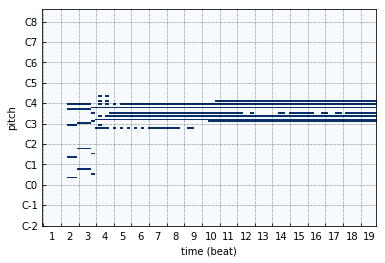

In [681]:
index=5
composer_index=3
print("composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(composer_index)]))
print("song composer = ",str(data.tags_ids.keys()[data.tags_ids.values().index(int(data[index][1]))]))
datp.gen_music_seconds_smooth(model,init=data[index][0].cuda(),composer=composer_index,fs=5,gen_seconds=10,init_seconds=3)

In [705]:
#datp.gen_music_seconds(model,init=data[index][0].cuda(),composer=composer_index,fs=5,gen_seconds=10,init_seconds=3)

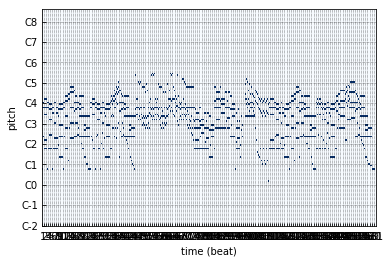

In [21]:
data.view_pianoroll(3)